# üå≤ Random Forest Models for Drug Sensitivity Prediction

This notebook trains a **Random Forest (RF)** regression model per drug using gene expression features (PCA or HVGs). RFs are robust, handle nonlinearities, and offer good interpretability with minimal hyperparameter tuning. We use **5-fold cross-validation** to evaluate each model‚Äôs performance with RMSE and R¬≤ metrics.



In [21]:
import os
import joblib
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


In [22]:
NUM_PCS = 20

# Choose your dataset (PCA or HVG)
DATA_PATH = "../../../data/processed/gdsc_pancancer_pseudobulk_30_pcs.parquet"
data = pd.read_parquet(DATA_PATH)

print("‚úÖ Dataset loaded:", data.shape)


‚úÖ Dataset loaded: (84683, 33)


### üîÅ Train One Random Forest Per Drug

For each drug, we train a separate RF model using its associated (cell line, IC50, features) data. We use train-test split and evaluate with RMSE and R¬≤.


In [23]:
os.makedirs("rf/models", exist_ok=True)
os.makedirs("rf/results", exist_ok=True)

non_features = ["SANGER_MODEL_ID", "DRUG_ID", "LN_IC50"]
gene_cols = [col for col in data.columns if col not in non_features]

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

results = []

for drug_id in sorted(data["DRUG_ID"].unique()):
    df = data[data["DRUG_ID"] == drug_id].dropna(subset=["LN_IC50"])
    if df.shape[0] < 100:
        print(f"‚ö†Ô∏è Skipped drug {drug_id} (samples: {df.shape[0]})")
        continue


    X = df[gene_cols].values.astype("float64")
    y = df["LN_IC50"].values.astype("float64")

    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        n_jobs=-1,
        random_state=42
    )

    rmse_scores = cross_val_score(model, X, y, cv=kf, scoring=rmse_scorer)
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring="r2")

    print(f"\nüå≤ Drug {drug_id} | Samples: {len(df)}")
    print(f"  ‚û§ RMSE (folds): {(-rmse_scores).round(4)} | Mean: {-rmse_scores.mean():.4f} ¬± {rmse_scores.std():.4f}")
    print(f"  ‚û§ R¬≤   (folds): {r2_scores.round(4)} | Mean: {r2_scores.mean():.4f} ¬± {r2_scores.std():.4f}")

    results.append({
        "DRUG_ID": drug_id,
        "n_samples": len(df),
        "rmse_mean": -rmse_scores.mean(),
        "rmse_std": rmse_scores.std(),
        "r2_mean": r2_scores.mean(),
        "r2_std": r2_scores.std()
    })

    model.fit(X, y)
    #joblib.dump(model, f"rf/models/rf_drug_{drug_id}.pkl")


‚ö†Ô∏è Skipped drug 1 (samples: 24)
‚ö†Ô∏è Skipped drug 3 (samples: 23)
‚ö†Ô∏è Skipped drug 5 (samples: 26)
‚ö†Ô∏è Skipped drug 6 (samples: 27)
‚ö†Ô∏è Skipped drug 9 (samples: 26)
‚ö†Ô∏è Skipped drug 11 (samples: 26)
‚ö†Ô∏è Skipped drug 17 (samples: 25)
‚ö†Ô∏è Skipped drug 29 (samples: 26)
‚ö†Ô∏è Skipped drug 30 (samples: 26)
‚ö†Ô∏è Skipped drug 32 (samples: 26)
‚ö†Ô∏è Skipped drug 34 (samples: 27)
‚ö†Ô∏è Skipped drug 35 (samples: 27)
‚ö†Ô∏è Skipped drug 37 (samples: 27)
‚ö†Ô∏è Skipped drug 38 (samples: 27)
‚ö†Ô∏è Skipped drug 41 (samples: 26)
‚ö†Ô∏è Skipped drug 45 (samples: 26)
‚ö†Ô∏è Skipped drug 51 (samples: 26)
‚ö†Ô∏è Skipped drug 52 (samples: 26)
‚ö†Ô∏è Skipped drug 53 (samples: 26)
‚ö†Ô∏è Skipped drug 54 (samples: 26)
‚ö†Ô∏è Skipped drug 55 (samples: 26)
‚ö†Ô∏è Skipped drug 56 (samples: 26)
‚ö†Ô∏è Skipped drug 59 (samples: 26)
‚ö†Ô∏è Skipped drug 60 (samples: 25)
‚ö†Ô∏è Skipped drug 62 (samples: 26)
‚ö†Ô∏è Skipped drug 63 (samples: 26)
‚ö†Ô∏è Skipped drug 64 (samples: 26)
‚ö†Ô∏è

In [24]:
results_df = pd.DataFrame(results)
results_df.to_csv(f"rf/results/pancancer_pseudobulk_30_pcs.csv", index=False)

print("üìÅ Saved to rf/results/model_performance_summary.csv")
results_df.head()


üìÅ Saved to rf/results/model_performance_summary.csv


DRUG_ID  n_samples  rmse_mean  rmse_std   r2_mean    r2_std
0      133        134   1.679442  0.254243 -0.009388  0.143006
1      134        134   1.841086  0.149036  0.023359  0.088083
2      135        133   2.506960  0.214145  0.049869  0.117104
3      136        135   1.484889  0.199349 -0.004691  0.098108
4      140        135   1.536668  0.102418  0.052609  0.064161

### üìä Distribution of RF Model Performance
We now visualize the RMSE and R¬≤ scores to analyze how well the RF models performed across all drugs.


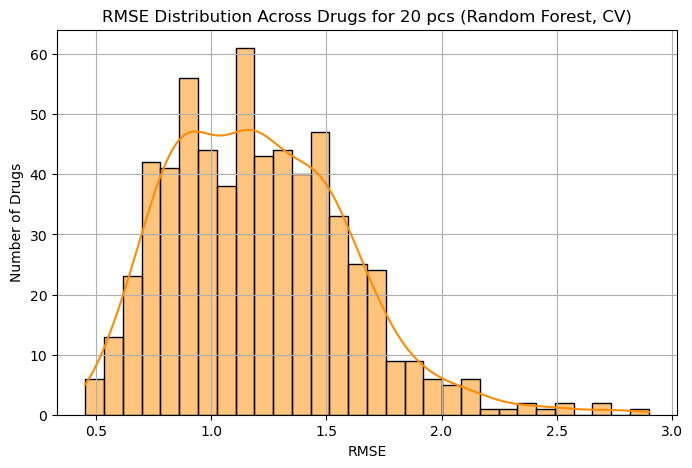

In [25]:
plt.figure(figsize=(8, 5))
sns.histplot(results_df["rmse_mean"], kde=True, bins=30, color="darkorange")
plt.title(f"RMSE Distribution Across Drugs for {NUM_PCS} pcs (Random Forest, CV)")
plt.xlabel("RMSE")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.show()
plt.close()

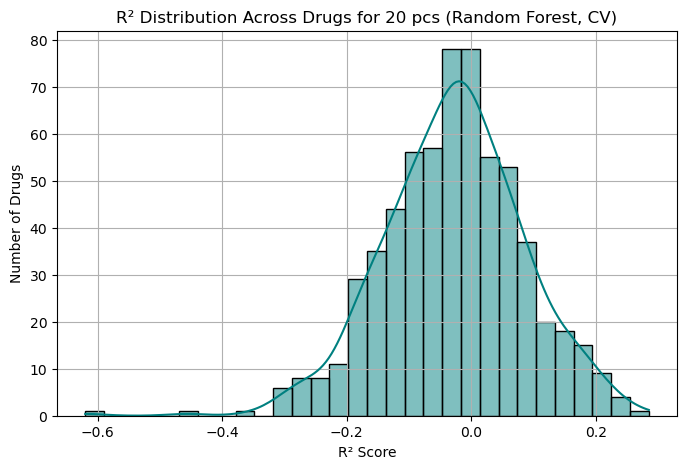

In [26]:
plt.figure(figsize=(8, 5))
sns.histplot(results_df["r2_mean"], kde=True, bins=30, color="teal")
plt.title(f"R¬≤ Distribution Across Drugs for {NUM_PCS} pcs (Random Forest, CV)")
plt.xlabel("R¬≤ Score")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.show()
plt.close()

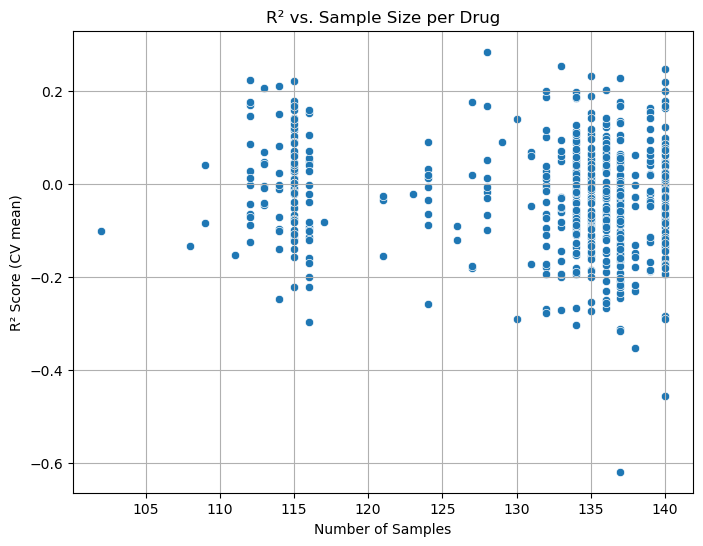

In [27]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x="n_samples", y="r2_mean", data=results_df)
plt.title("R¬≤ vs. Sample Size per Drug")
plt.xlabel("Number of Samples")
plt.ylabel("R¬≤ Score (CV mean)")
plt.grid(True)
plt.show()


In [28]:
from scipy.stats import pearsonr, spearmanr

# Pearson (linear)
pearson_corr, pval_pearson = pearsonr(results_df["n_samples"], results_df["r2_mean"])
print(f"üìä Pearson r = {pearson_corr:.3f} (p = {pval_pearson:.3g})")

# Spearman (rank-based, robust to non-linearities)
spearman_corr, pval_spearman = spearmanr(results_df["n_samples"], results_df["r2_mean"])
print(f"üìä Spearman œÅ = {spearman_corr:.3f} (p = {pval_spearman:.3g})")


üìä Pearson r = -0.118 (p = 0.00306)
üìä Spearman œÅ = -0.092 (p = 0.0214)


Text(0.5, 1.0, 'R¬≤ vs. IC50 Variance')

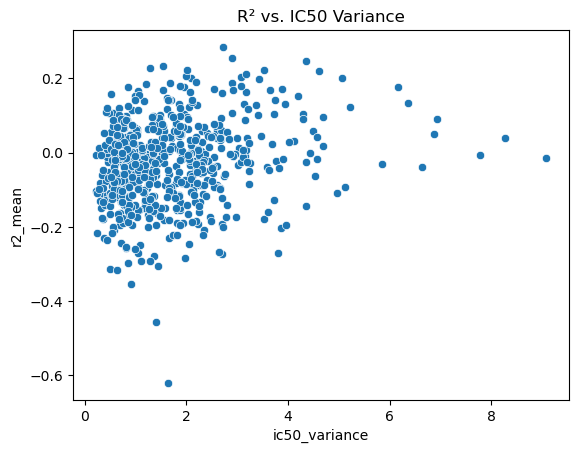

In [29]:
variances = data.groupby("DRUG_ID")["LN_IC50"].var()
results_df = results_df.merge(variances.rename("ic50_variance"), on="DRUG_ID")
sns.scatterplot(data=results_df, x="ic50_variance", y="r2_mean")
plt.title("R¬≤ vs. IC50 Variance")
